![Bluemetrica](../bluemetrica_large.png)

# Problem regresji (prognozujemy ceny domów)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import cluster
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Wczytujemy dane

In [2]:
df = pd.read_csv("../house data/train.csv", index_col = 0)

### Informacja na temat danych

*source: kaggle.com*

Set contains data about home prices in one of the towns in Iowa

-	**SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
-	**MSSubClass**: The building class
-	**MSZoning**: The general zoning classification
-	**LotFrontage**: Linear feet of street connected to property
-	**LotArea**: Lot size in square feet
-	**Street**: Type of road access
-	**Alley**: Type of alley access
-	**LotShape**: General shape of property
-	**LandContour**: Flatness of the property
-	**Utilities**: Type of utilities available
-	**LotConfig**: Lot configuration
-	**LandSlope**: Slope of property
-	**Neighborhood**: Physical locations within Ames city limits
-	**Condition1**: Proximity to main road or railroad
-	**Condition2**: Proximity to main road or railroad (if a second is present)
-	**BldgType**: Type of dwelling
-	**HouseStyle**: Style of dwelling
-	**OverallQual**: Overall material and finish quality
-	**OverallCond**: Overall condition rating
-	**YearBuilt**: Original construction date
-	**YearRemodAdd**: Remodel date
-	**RoofStyle**: Type of roof
-	**RoofMatl**: Roof material
-	**Exterior1st**: Exterior covering on house
-	**Exterior2nd**: Exterior covering on house (if more than one material)
-	**MasVnrType**: Masonry veneer type
-	**MasVnrArea**: Masonry veneer area in square feet
-	**ExterQual**: Exterior material quality
-	**ExterCond**: Present condition of the material on the exterior
-	**Foundation**: Type of foundation
-	**BsmtQual**: Height of the basement
-	**BsmtCond**: General condition of the basement
-	**BsmtExposure**: Walkout or garden level basement walls
-	**BsmtFinType1**: Quality of basement finished area
-	**BsmtFinSF1**: Type 1 finished square feet
-	**BsmtFinType2**: Quality of second finished area (if present)
-	**BsmtFinSF2**: Type 2 finished square feet
-	**BsmtUnfSF**: Unfinished square feet of basement area
-	**TotalBsmtSF**: Total square feet of basement area
-	**Heating**: Type of heating
-	**HeatingQC**: Heating quality and condition
-	**CentralAir**: Central air conditioning
-	**Electrical**: Electrical system
-	**1stFlrSF**: First Floor square feet
-	**2ndFlrSF**: Second floor square feet
-	**LowQualFinSF**: Low quality finished square feet (all floors)
-	**GrLivArea**: Above grade (ground) living area square feet
-	**BsmtFullBath**: Basement full bathrooms
-	**BsmtHalfBath**: Basement half bathrooms
-	**FullBath**: Full bathrooms above grade
-	**HalfBath**: Half baths above grade
-	**Bedroom**: Number of bedrooms above basement level
-	**Kitchen**: Number of kitchens
-	**KitchenQual**: Kitchen quality
-	**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
-	**Functional**: Home functionality rating
-	**Fireplaces**: Number of fireplaces
-	**FireplaceQu**: Fireplace quality
-	**GarageType**: Garage location
-	**GarageYrBlt**: Year garage was built
-	**GarageFinish**: Interior finish of the garage
-	**GarageCars**: Size of garage in car capacity
-	**GarageArea**: Size of garage in square feet
-	**GarageQual**: Garage quality
-	**GarageCond**: Garage condition
-	**PavedDrive**: Paved driveway
-	**WoodDeckSF**: Wood deck area in square feet
-	**OpenPorchSF**: Open porch area in square feet
-	**EnclosedPorch**: Enclosed porch area in square feet
-	**3SsnPorch**: Three season porch area in square feet
-	**ScreenPorch**: Screen porch area in square feet
-	**PoolArea**: Pool area in square feet
-	**PoolQC**: Pool quality
-	**Fence**: Fence quality
-	**MiscFeature**: Miscellaneous feature not covered in other categories
-	**MiscVal**: $Value of miscellaneous feature
-	**MoSold**: Month Sold
-	**YrSold**: Year Sold
-	**SaleType**: Type of sale
-	**SaleCondition**: Condition of sale


### Oglądamy dane, sprawdzamy brakujące wartości

#### Braki w zmiennej lot frontage

Lot frontage to szerokość działki tam gdzie przylega ona do ulicy:
![Lot frontage](./lot_frontage.png)

Każda działka ma jakąś szerokość, NA to brak tej informacji. Możemy wstawić zamiast NA średnią szerokość lub próbować zbudować prosty model regresji liniowej wyjaśniający szerokość działki w zależności od powierzchni działki, dzielnicy i wielkości domu. 

#### Inne braki
Fragment kodu poniżej przyda nam się później

`
#Brakujące (w sposób losowy) dane liczbowe wypełnimy medianami, brakujące kategorie - modą czyli inaczej dominantą

df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace = True)
df['MasVnrArea'].fillna(df['MasVnrArea'].median(), inplace = True)
df['MasVnrType'].fillna(df['MasVnrType'].mode()[0], inplace = True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace = True)`

In [3]:
df.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 37 columns]

In [4]:
df.shape

(1460, 80)

In [5]:
df.isnull().mean().sort_values(ascending = False).round(3)

PoolQC           0.995
MiscFeature      0.963
Alley            0.938
Fence            0.808
FireplaceQu      0.473
LotFrontage      0.177
GarageType       0.055
GarageCond       0.055
GarageFinish     0.055
GarageQual       0.055
GarageYrBlt      0.055
BsmtFinType2     0.026
BsmtExposure     0.026
BsmtQual         0.025
BsmtCond         0.025
BsmtFinType1     0.025
MasVnrArea       0.005
MasVnrType       0.005
Electrical       0.001
RoofMatl         0.000
Exterior1st      0.000
RoofStyle        0.000
ExterQual        0.000
Exterior2nd      0.000
YearBuilt        0.000
ExterCond        0.000
Foundation       0.000
YearRemodAdd     0.000
SalePrice        0.000
OverallCond      0.000
                 ...  
GarageArea       0.000
PavedDrive       0.000
WoodDeckSF       0.000
OpenPorchSF      0.000
3SsnPorch        0.000
BsmtUnfSF        0.000
ScreenPorch      0.000
PoolArea         0.000
MiscVal          0.000
MoSold           0.000
YrSold           0.000
SaleType         0.000
Functional 

In [6]:
df['PoolArea'].value_counts()

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [7]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

### Usuwamy zmienne dla których brakuje ponad 60% danych

In [8]:
df.dropna(axis = 1, thresh = np.floor(0.4 * df.shape[0]), inplace = True)

In [9]:
df.isnull().mean().sort_values(ascending = False).round(3)

FireplaceQu      0.473
LotFrontage      0.177
GarageCond       0.055
GarageType       0.055
GarageYrBlt      0.055
GarageFinish     0.055
GarageQual       0.055
BsmtExposure     0.026
BsmtFinType2     0.026
BsmtFinType1     0.025
BsmtCond         0.025
BsmtQual         0.025
MasVnrType       0.005
MasVnrArea       0.005
Electrical       0.001
YearBuilt        0.000
Exterior2nd      0.000
Exterior1st      0.000
ExterQual        0.000
ExterCond        0.000
Foundation       0.000
RoofMatl         0.000
RoofStyle        0.000
YearRemodAdd     0.000
SalePrice        0.000
OverallCond      0.000
OverallQual      0.000
HouseStyle       0.000
BldgType         0.000
Condition2       0.000
                 ...  
GarageArea       0.000
PavedDrive       0.000
WoodDeckSF       0.000
OpenPorchSF      0.000
3SsnPorch        0.000
BsmtUnfSF        0.000
ScreenPorch      0.000
PoolArea         0.000
MiscVal          0.000
MoSold           0.000
YrSold           0.000
SaleType         0.000
Functional 

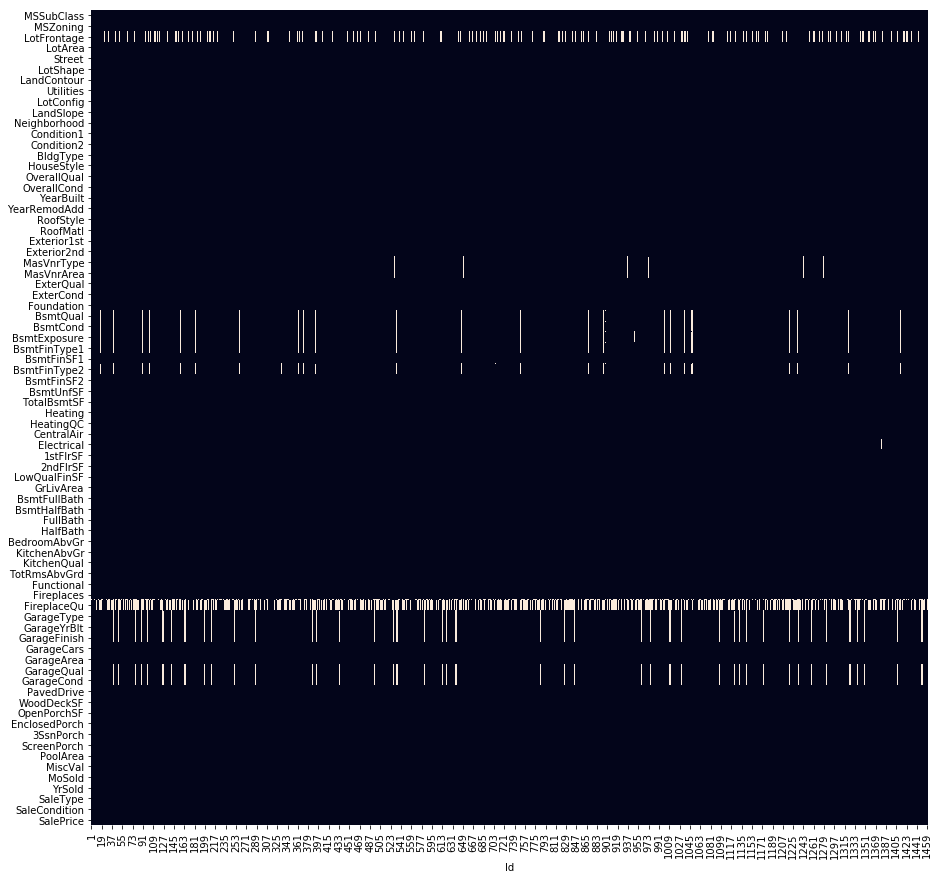

In [10]:
# Heatmapa brakujących wartości
plt.figure(figsize = (15,15))
sns.heatmap(df.isnull().T, cbar = False) # T - transpozycja

In [11]:
df['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [12]:
# czy braki w FireplaceQu są tylko dla Fireplaces == 0?
df.groupby('Fireplaces').apply(lambda x: pd.isnull(x).mean())['FireplaceQu']

Fireplaces
0    1.0
1    0.0
2    0.0
3    0.0
Name: FireplaceQu, dtype: float64

In [13]:
df['FireplaceQu'].fillna("No", inplace = True)

In [14]:
df.isnull().mean().sort_values(ascending = False).round(3)

LotFrontage      0.177
GarageFinish     0.055
GarageType       0.055
GarageYrBlt      0.055
GarageCond       0.055
GarageQual       0.055
BsmtFinType2     0.026
BsmtExposure     0.026
BsmtFinType1     0.025
BsmtCond         0.025
BsmtQual         0.025
MasVnrArea       0.005
MasVnrType       0.005
Electrical       0.001
RoofMatl         0.000
Exterior1st      0.000
ExterQual        0.000
Exterior2nd      0.000
YearRemodAdd     0.000
ExterCond        0.000
Foundation       0.000
BsmtFinSF1       0.000
RoofStyle        0.000
SalePrice        0.000
YearBuilt        0.000
LotConfig        0.000
MSZoning         0.000
LotArea          0.000
Street           0.000
LotShape         0.000
                 ...  
GarageArea       0.000
PavedDrive       0.000
WoodDeckSF       0.000
OpenPorchSF      0.000
3SsnPorch        0.000
TotalBsmtSF      0.000
ScreenPorch      0.000
PoolArea         0.000
MiscVal          0.000
MoSold           0.000
YrSold           0.000
SaleType         0.000
Fireplaces 

In [15]:
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace = True)
df['MasVnrArea'].fillna(df['MasVnrArea'].median(), inplace = True)
df['MasVnrType'].fillna(df['MasVnrType'].mode()[0], inplace = True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace = True)

df['GarageYrBlt'].fillna(0, inplace = True)

In [16]:
df['MasVnrType'].value_counts()

None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [17]:
df.fillna("None", inplace = True)

In [18]:
# nie mamy już braków w danych
df.isnull().sum().sum()

0

## Wizualizacja danych i przekodowanie zmiennych

- Neighbourhood - czy cena domu zależy od dzielnicy?
- MSSubClass - czy te kolejne wartości są narastające (malejące) czy te kategorie sa przypadkowe?
- Czy ilość kominków wpływa na cenę?
- Czy powierzchnia domu wpływa na cenę? GrLivArea
- Czy liczba łazienek wpływa na cenę? FullBath
- Czy rok budowy wpływa na cenę - YearBuilt
- Czy jakość domu wpływa na cenę? OverallQual


- Czy rok/miesiąc sprzedazy wpływa na cenę?
- W którym miesiącu jest najwięcej transakcji?

boxplot, pairplot, heatmapa korelacji, barplot, countplot ...

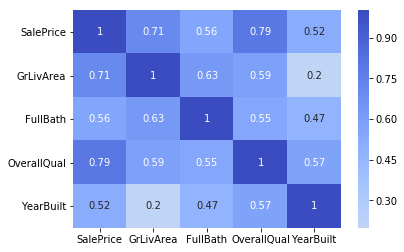

In [19]:
sns.heatmap(df[['SalePrice', 'GrLivArea', 'FullBath', 'OverallQual', 'YearBuilt']].corr(),
           cmap = 'coolwarm_r', center = 0, annot = True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


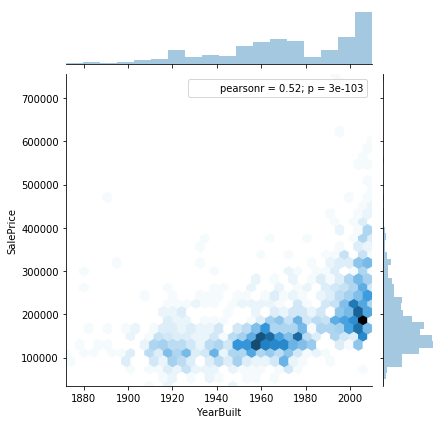

In [20]:
sns.jointplot(x = 'YearBuilt', y = 'SalePrice', data = df, kind = 'hex')

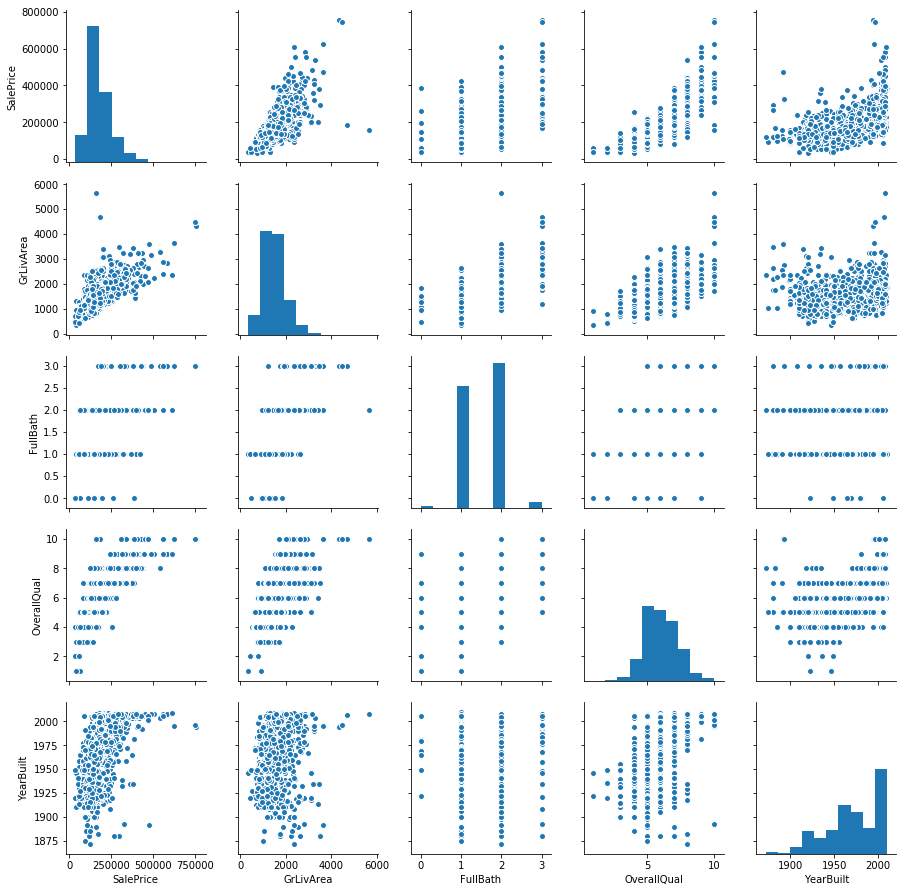

In [21]:
sns.pairplot(data = df, vars = ['SalePrice', 'GrLivArea', 'FullBath', 'OverallQual', 'YearBuilt'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


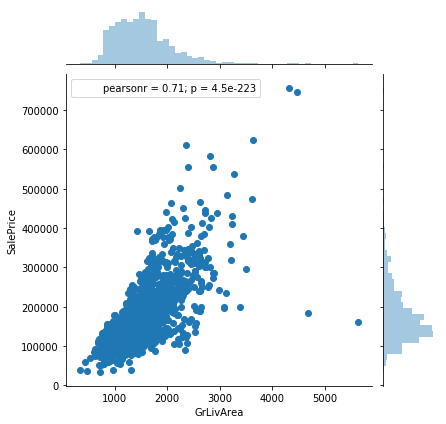

In [22]:
# Outliery?
sns.jointplot(x = 'GrLivArea', y = 'SalePrice', data = df)

In [23]:
# usuwamy 2 outliery - duże domy, tanio sprzedane
df.drop(df[(df['GrLivArea'] > 4200) & (df['SalePrice'] < 300000)].index, inplace = True)

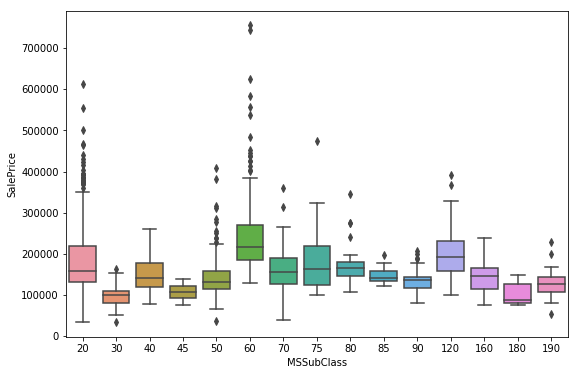

In [24]:
# MSSubClass - czy te kolejne wartości są narastające (malejące) czy te kategorie sa przypadkowe?
plt.figure(figsize = (9,6))
sns.boxplot(x = 'MSSubClass', y = 'SalePrice', data = df)

In [25]:
df['MSSubClass'] = df['MSSubClass'].astype('str')

### Neighbourhood - czy cena domu zależy od dzielnicy?

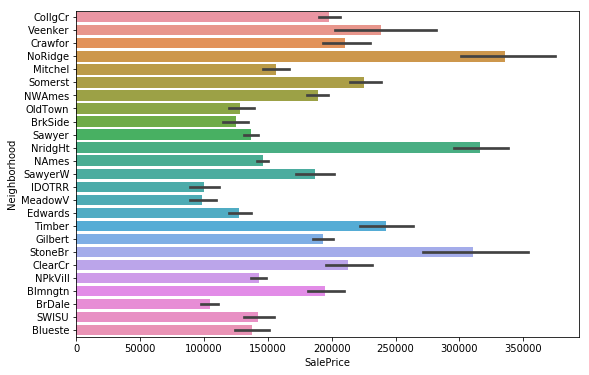

In [26]:
plt.figure(figsize = (9,6)) 
sns.barplot(y = 'Neighborhood', x = 'SalePrice', data = df)

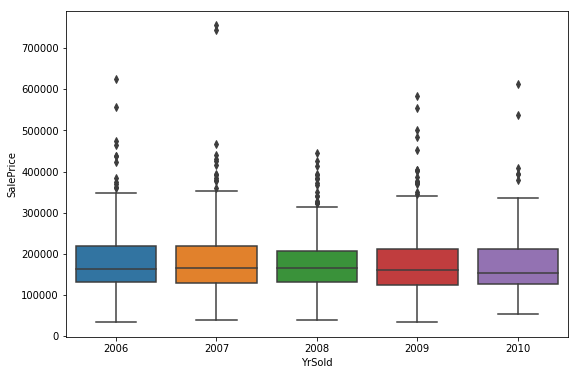

In [27]:
plt.figure(figsize = (9,6))
sns.boxplot(x = 'YrSold', y = 'SalePrice', data = df)

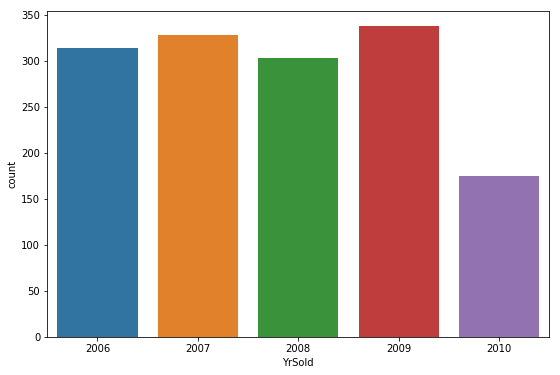

In [28]:
plt.figure(figsize = (9,6))
sns.countplot(x = 'YrSold', data = df)

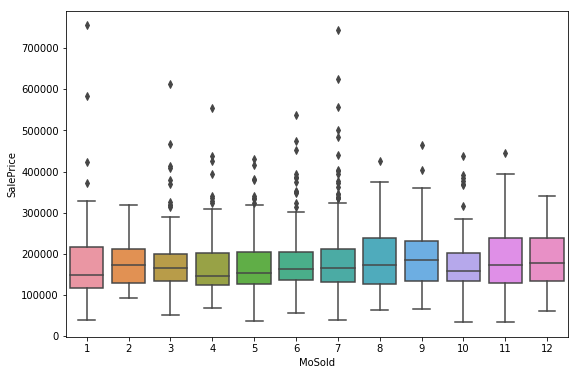

In [29]:
plt.figure(figsize = (9,6))
sns.boxplot(x = 'MoSold', y = 'SalePrice', data = df)

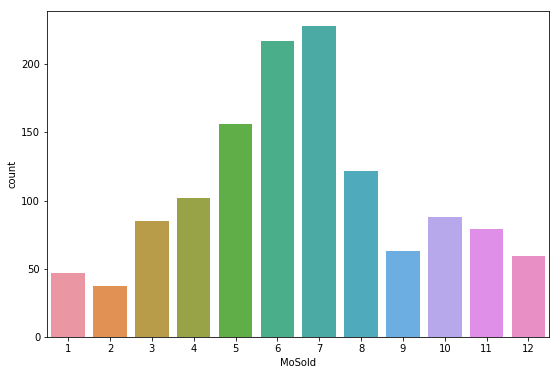

In [82]:
plt.figure(figsize = (9,6))
sns.countplot(x = 'MoSold', data = df[df['YrSold'] != 2010])

# H2O - RF

In [86]:
import h2o

In [87]:
h2o.cluster().shutdown()

H2O session _sid_89ca closed.


In [88]:
h2o.init(max_mem_size = '8G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ewaru\AppData\Local\Temp\tmp1ni7ixnu
  JVM stdout: C:\Users\ewaru\AppData\Local\Temp\tmp1ni7ixnu\h2o_ewaru_started_from_python.out
  JVM stderr: C:\Users\ewaru\AppData\Local\Temp\tmp1ni7ixnu\h2o_ewaru_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ------------------------------
H2O cluster uptime:         07 secs
H2O cluster version:        3.10.4.8
H2O cluster version age:    1 year and 5 days !!!
H2O cluster name:           H2O_from_python_ewaru_5fiwer
H2O cluster total nodes:    1
H2O cluster free memory:    7.111 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.6.3 final
--------------------------  ------------------------------

Zbiór treningowy i testowy i walidacyjny    
test size = 0.2

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = df.columns.drop('SalePrice')
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(df[X], y, test_size=0.2, random_state=200)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=200)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1049, 75)
(292, 75)
(117, 75)


### Import danych do klastra

In [96]:
train = h2o.H2OFrame(pd.concat([X_train, y_train], axis = 1))
test = h2o.H2OFrame(pd.concat([X_test, y_test], axis = 1))
val = h2o.H2OFrame(pd.concat([X_val, y_val], axis = 1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [98]:
# pomoc do modeli z h2o
help(h2o.estimators.H2ORandomForestEstimator)

Help on class H2ORandomForestEstimator in module h2o.estimators.random_forest:

class H2ORandomForestEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Distributed Random Forest
 |  
 |  Method resolution order:
 |      H2ORandomForestEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      h2o.utils.backward_compatibility.BackwardsCompatibleBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      Construct a new model instance.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  balance_classes
 |      Balance training data class counts via over/under-sampling (for imbalanced data).
 |      
 |      Type: ``bool``  (default: ``False``).
 |  
 |  binomial_double_trees
 |      For binary classification: Build 2x as many trees (one per class) - can lead to higher accuracy.
 |      
 |      Type: ``bool``  (default: 

## Model RF

In [100]:
model_rf = h2o.estimators.H2ORandomForestEstimator(ntrees = 1000,
                                                   max_depth = 20,
                                                   mtries = 50,
                                                   sample_rate = 0.632,
                                                   stopping_rounds = 100,
                                                   # ustawienia CV
                                                   nfolds = 10,
                                                   fold_assignment = "Modulo",
                                                   keep_cross_validation_predictions = True)

In [101]:
model_rf.train(x = list(X), y = 'SalePrice', training_frame= train, validation_frame= val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [102]:
model_rf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1527346894444_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 655410397.5471268
RMSE: 25600.984308169223
MAE: 16009.568828291352
RMSLE: 0.13269682274450578
Mean Residual Deviance: 655410397.5471268

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 816441914.7813184
RMSE: 28573.447723040328
MAE: 18064.497836605235
RMSLE: 0.17805340268147363
Mean Residual Deviance: 816441914.7813184

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 694075363.4293138
RMSE: 26345.31008413668
MAE: 16311.259887467228
RMSLE: 0.1350647141799277
Mean Residual Deviance: 694075363.4293138
Cross-Validation Metrics Summary: 


mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
-----------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                16312.2      1613.06      16554.6       15772.9       13460.3       14147.1       17721.3       18302.4       21177.8       14906.1       13796.5       17282.8
mse                6.94137e+08  2.20009e+08  5.92372e+08   7.09003e+08   3.58387e+08   4.79379e+08   6.13461e+08   1.12819e+09   1.37762e+09   5.73646e+08   3.50735e+08   7.58574e+08
r2                 0.880361     0.0254136    0.898995      0.880818      0.940162      0.886558      0.89863       0.857458      0.850854      0.811011      0.923084      0.856041
residual_deviance  6.94137e+08  2.20009e+08  5.92372e+08   7.09003e+08   3.58387e+08   4.79379e+08   6.13461e+08   1.12819e+09   1.37762e+09   5.73646e+08   3.50735e+08   7.58574e+08
rmse               25748.6      3946.39      24338.7       26627.1       18931.1       21894.7       24768.1       33588.5       37116.3       23950.9       18727.9       27542.2
rmsle              0.133449     0.0147285    0.165176      0.123098      0.113587      0.107796      0.137889      0.157688      0.160481      0.127978      0.105171      0.13563

Scoring History: 


timestamp            duration          number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2018-05-26 17:30:14  6 min 54.588 sec  0.0                nan                 nan                 nan                  nan                 nan                 nan
     2018-05-26 17:30:14  6 min 54.722 sec  1.0                46807.658726896974  30540.75888324873   2190956915.4936547   38122.80060563618   27278.495726495727  1453347926.0170941
     2018-05-26 17:30:14  6 min 54.807 sec  2.0                45572.88389513229   29335.828003120125  2076887746.5192082   37806.17958187422   24539.17948717949   1429307214.5769231
     2018-05-26 17:30:14  6 min 54.907 sec  3.0                40333.512145817695  27143.42787025181   1626792202.0168233   34018.96381775344   22084.01994301995   1157289899.2336178
     2018-05-26 17:30:15  6 min 54.983 sec  4.0                37338.454228754206  24722.97572586727   1394160164.192773    31488.335222328253  21176.41452991453   991515255.073718
---  ---                  ---               ---                ---                 ---                 ---                  ---                 ---                 ---
     2018-05-26 17:31:15  7 min 55.715 sec  814.0              25621.252786415447  16053.561865347072  656448594.3454013    28678.904216022158  18164.792266479762  822479547.0317734
     2018-05-26 17:31:19  7 min 59.739 sec  862.0              25615.517905035016  16050.582364393595  656154757.5431695    28646.901084074958  18145.061888580894  820644941.720775
     2018-05-26 17:31:23  8 min  3.747 sec  912.0              25597.91314392622   16039.60005278728   655253157.3239908    28605.462950573314  18125.340101765167  818272510.6166226
     2018-05-26 17:31:27  8 min  7.793 sec  966.0              25620.666195486257  16033.66047122855   656418536.3005322    28604.18829335216   18094.57036143958   818199587.9215448
     2018-05-26 17:31:30  8 min 10.388 sec  1000.0             25600.984308169223  16009.568828291352  655410397.5471268    28573.447723040328  18064.497836605235  816441914.7813184


See the whole table with table.as_data_frame()
Variable Importances: 


variable      relative_importance    scaled_importance       percentage
------------  ---------------------  ----------------------  ----------------------
OverallQual   2309724963864576.0     1.0                     0.48243429157290474
ExterQual     459472346546176.0      0.19892946291639763     0.09597039451505071
Neighborhood  389198192312320.0      0.16850412858729422     0.08129216990212093
GrLivArea     350933758246912.0      0.1519374660348036      0.07329984378988276
BsmtFinSF1    172400054370304.0      0.07464094516337928     0.036009351502226915
---           ---                    ---                     ---
MiscVal       438560391168.0         0.00018987559039679397  9.160249594006433e-05
3SsnPorch     209373052928.0         9.064847815372877e-05   4.3731934340256076e-05
Condition2    151912071168.0         6.577063223745238e-05   3.173000836977739e-05
Street        47363248128.0          2.0506012130878543e-05  9.892803435345781e-06
Utilities     1006964032.0           4.359670730298434e-07   2.1032546602626532e-07


See the whole table with table.as_data_frame()


In [104]:
model_rf.model_performance(test_data = test)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 838673558.2045859
RMSE: 28959.861156514304
MAE: 18653.024910744858
RMSLE: 0.14602888065170375
Mean Residual Deviance: 838673558.2045859


In [105]:
# sprawdzamy jaki jest rozkład zmiennej sale price
df['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Zapisywanie i wczytywanie modelu h2o

In [106]:
# zapisuję model do folderu model_ranfom_forest
h2o.save_model(model_rf, "/model_random_forest")

'C:\\model_random_forest\\DRF_model_python_1527346894444_1'

In [107]:
# wczytuję model
# model_wczytany = h2o.load_model("/model_random_forest")

In [108]:
model_rf.model_id

'DRF_model_python_1527346894444_1'

## Importance - zmienne użyte do budowy modelu

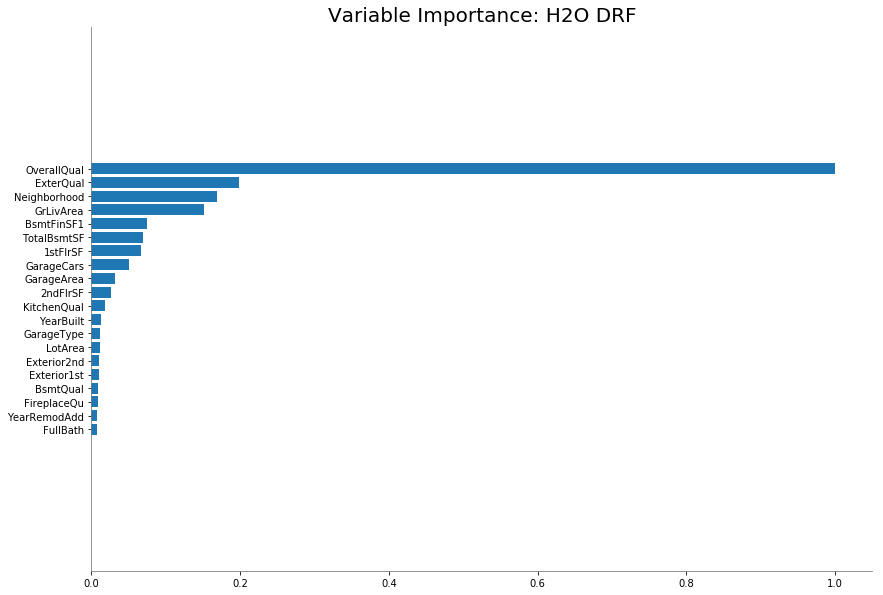

In [112]:
model_rf.varimp_plot(20)

In [114]:
model_rf.varimp(use_pandas=True).sort_values(by = 'relative_importance')

variable  relative_importance  scaled_importance    percentage
74      Utilities         1.006964e+09       4.359671e-07  2.103255e-07
73         Street         4.736325e+10       2.050601e-05  9.892803e-06
72     Condition2         1.519121e+11       6.577063e-05  3.173001e-05
71      3SsnPorch         2.093731e+11       9.064848e-05  4.373193e-05
70        MiscVal         4.385604e+11       1.898756e-04  9.160250e-05
69     Electrical         5.500828e+11       2.381595e-04  1.148963e-04
68        Heating         5.969501e+11       2.584507e-04  1.246855e-04
67   KitchenAbvGr         8.257013e+11       3.574890e-04  1.724650e-04
66   LowQualFinSF         9.465538e+11       4.098123e-04  1.977075e-04
65     PavedDrive         1.026406e+12       4.443844e-04  2.143863e-04
64     Functional         1.562989e+12       6.766994e-04  3.264630e-04
63      LandSlope         1.696048e+12       7.343073e-04  3.542550e-04
62     BsmtFinSF2         1.733437e+12       7.504952e-04  3.620646e-04
61       RoofMatl         1.755580e+12       7.600818e-04  3.666895e-04
60   BsmtFinType2         1.960194e+12       8.486697e-04  4.094274e-04
59       BldgType         2.002807e+12       8.671191e-04  4.183280e-04
58  EnclosedPorch         2.035791e+12       8.813999e-04  4.252176e-04
57      ExterCond         2.211910e+12       9.576507e-04  4.620035e-04
56   BsmtHalfBath         2.223317e+12       9.625896e-04  4.643862e-04
55     Condition1         2.441927e+12       1.057237e-03  5.100475e-04
54     GarageCond         2.603905e+12       1.127366e-03  5.438799e-04
53       BsmtCond         2.606767e+12       1.128605e-03  5.444777e-04
52    ScreenPorch         2.919778e+12       1.264124e-03  6.098567e-04
51     GarageQual         2.960596e+12       1.281796e-03  6.183822e-04
50       PoolArea         3.071135e+12       1.329654e-03  6.414708e-04
49     Foundation         3.272276e+12       1.416738e-03  6.834832e-04
48       LotShape         3.298035e+12       1.427891e-03  6.888634e-04
47    LandContour         3.395462e+12       1.470072e-03  7.092132e-04
46      HeatingQC         3.512443e+12       1.520719e-03  7.336471e-04
45      RoofStyle         3.587406e+12       1.553174e-03  7.493046e-04
..            ...                  ...                ...           ...
29    OverallCond         9.693387e+12       4.196771e-03  2.024666e-03
28     MasVnrArea         9.860616e+12       4.269173e-03  2.059596e-03
27         MoSold         1.063561e+13       4.604710e-03  2.221470e-03
26   TotRmsAbvGrd         1.314752e+13       5.692246e-03  2.746135e-03
25    LotFrontage         1.346088e+13       5.827914e-03  2.811585e-03
24   GarageFinish         1.353832e+13       5.861441e-03  2.827760e-03
23      BsmtUnfSF         1.496202e+13       6.477837e-03  3.125130e-03
22   BsmtFinType1         1.497060e+13       6.481553e-03  3.126923e-03
21   BsmtExposure         1.524296e+13       6.599469e-03  3.183810e-03
20    OpenPorchSF         1.733060e+13       7.503316e-03  3.619857e-03
19       FullBath         1.845717e+13       7.991070e-03  3.855166e-03
18   YearRemodAdd         1.881069e+13       8.144125e-03  3.929005e-03
17    FireplaceQu         2.015870e+13       8.727751e-03  4.210566e-03
16       BsmtQual         2.086776e+13       9.034737e-03  4.358667e-03
15    Exterior1st         2.271452e+13       9.834294e-03  4.744401e-03
14    Exterior2nd         2.526320e+13       1.093775e-02  5.276748e-03
13        LotArea         2.651742e+13       1.148077e-02  5.538716e-03
12     GarageType         2.798052e+13       1.211422e-02  5.844316e-03
11      YearBuilt         3.092048e+13       1.338708e-02  6.458387e-03
10    KitchenQual         4.307395e+13       1.864895e-02  8.996894e-03
9        2ndFlrSF         6.160720e+13       2.667296e-02  1.286795e-02
8      GarageArea         7.276994e+13       3.150589e-02  1.519952e-02
7      GarageCars         1.180848e+14       5.112507e-02  2.466448e-02
6        1stFlrSF         1.535330e+14       6.64

In [115]:
df['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

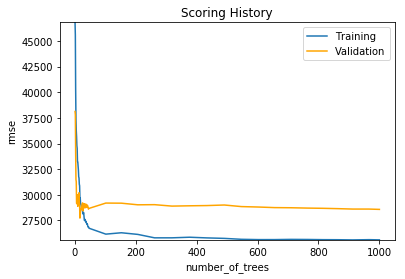

In [116]:
# jak trenował się nasz model?
model_rf.plot()

In [120]:
# Predykcje z modelu
pred_rf = model_rf.predict(test).as_data_frame()
pred_rf

drf prediction progress: |████████████████████████████████████████████████| 100%


predict
0    138403.853000
1    141161.956656
2    410234.311000
3    222574.348672
4    129202.022211
5    142914.015000
6    151752.278000
7    144112.176641
8    142524.353578
9    213984.637328
10   135291.242664
11   197098.429500
12   123271.098000
13   209197.706000
14   174598.342000
15   205316.840781
16   138510.138312
17   227174.478000
18   134361.304672
19   155295.821828
20   173510.537000
21   183894.015000
22   139792.613000
23   171756.073250
24   186129.421000
25   173442.812500
26   209462.859000
27   268588.330500
28   138235.299023
29   159140.662625
..             ...
262  149737.932578
263  121287.446047
264  166613.974000
265  162657.108000
266  240654.387000
267  102067.199109
268  220935.050000
269  182847.472172
270  103138.593664
271  212401.153000
272   77201.796000
273  293663.353000
274  199630.790000
275  173208.474000
276  298755.168500
277  123916.363164
278  204842.831672
279  146979.102328
280  232173.288000
281   85427.216000
282  156967.527000
283  150463.407672
284  106954.555000
285  170611.282000
286  141123.292797
287  194597.332547
288  164137.947000
289  203147.495469
290  161729.060656
291  130600.744000

[292 rows x 1 columns]

In [139]:
# RMSPE - pierwiastek średniokwadratowego błędu procentowego
np.sqrt(sum(((np.array(y_test) - np.array(pred_rf)[:,0])/np.array(y_test))**2)/y_test.shape[0])

0.16906003179849655

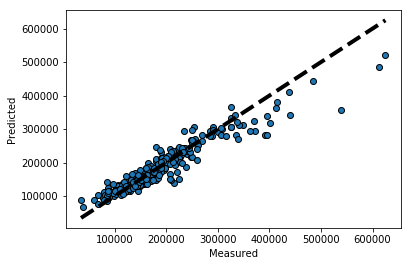

In [143]:
# predicted vs actuals
fig, ax = plt.subplots()
ax.scatter(np.array(y_test), np.array(pred_rf)[:,0], edgecolors=(0, 0, 0))

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

## Gradient boosting
Xgboost

In [145]:
model_gbm = h2o.estimators.H2OGradientBoostingEstimator(ntrees = 1000,
                                                   max_depth = 10,
                                                   col_sample_rate = 0.4,
                                                   sample_rate = 0.632,
                                                   stopping_rounds = 100,
                                                   learn_rate = 0.01,# eta
                                                   # ustawienia CV
                                                   nfolds = 10,
                                                   fold_assignment = "Modulo",
                                                   keep_cross_validation_predictions = True)

In [146]:
model_gbm.train(x = list(X),
                y = 'SalePrice',
                training_frame= train,
                validation_frame= val)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


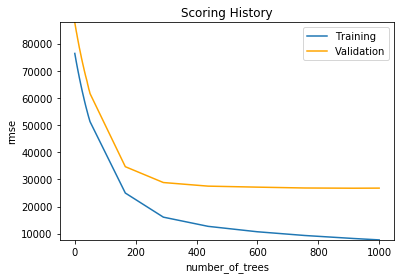

In [147]:
model_gbm.plot()

In [148]:
model_gbm.model_performance(test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 647401378.4234453
RMSE: 25444.08336771921
MAE: 16475.665369924438
RMSLE: 0.12278951552711079
Mean Residual Deviance: 647401378.4234453


In [149]:
pred_gbm = model_gbm.predict(test).as_data_frame()
pred_gbm

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
0    125034.113109
1    137522.241212
2    501128.105402
3    220724.708539
4    134694.968895
5    145830.647890
6    154006.761482
7    143084.659216
8    148495.735211
9    206131.601830
10   138243.699652
11   205630.395450
12   113709.810250
13   216042.737556
14   174642.364401
15   190816.331887
16   133234.501900
17   243359.349836
18   138364.198223
19   144826.577708
20   173804.469372
21   184403.493754
22   145397.775785
23   169218.804558
24   195556.470011
25   181608.757329
26   213372.396881
27   263879.836715
28   136331.756504
29   165416.645044
..             ...
262  176327.674411
263  121184.153487
264  152755.411974
265  167941.686475
266  233135.950521
267   88394.843377
268  212681.835194
269  175664.439033
270  106652.318237
271  218820.456539
272   65856.736140
273  315370.429145
274  201568.764127
275  178695.198554
276  309435.333781
277  120046.394148
278  199179.049792
279  144479.927033
280  228706.577064
281   77880.829969
282  158035.483886
283  148540.668863
284  107031.328882
285  159391.558395
286  143259.222621
287  189768.118042
288  178273.901907
289  199869.680865
290  167057.906295
291  140116.978120

[292 rows x 1 columns]

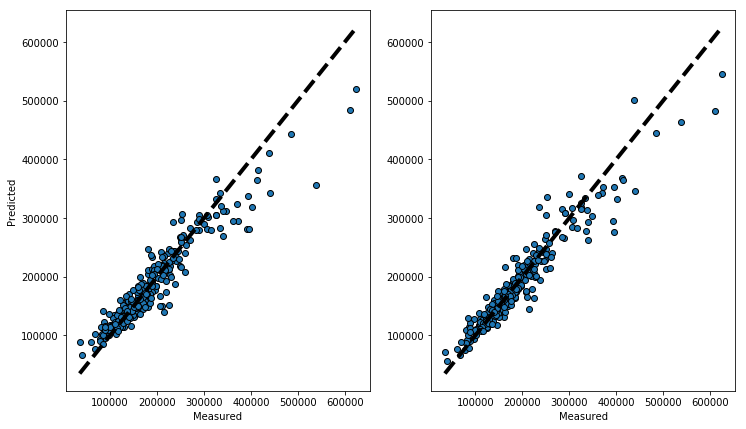

In [159]:
# predicted vs actuals
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12,7))
ax.scatter(np.array(y_test), np.array(pred_rf)[:,0], edgecolors=(0, 0, 0))

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)


ax2.scatter(np.array(y_test), np.array(pred_gbm)[:,0], edgecolors=(0, 0, 0))

ax2.set_xlabel('Measured')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

## Złożenie modeli

In [165]:
pred = 0.3 * pred_rf + 0.7 * pred_gbm

In [166]:
# rmspe
np.sqrt(sum(((np.array(y_test) - np.array(pred)[:,0])/np.array(y_test))**2)/y_test.shape[0])

0.14288666059611133

In [167]:
# rmse
np.sqrt(sum(((np.array(y_test) - np.array(pred_rf)[:,0]))**2)/y_test.shape[0])

28959.8611565143

In [168]:
# błąd % z gbm
np.sqrt(sum(((np.array(y_test) - np.array(pred_gbm)[:,0])/np.array(y_test))**2)/y_test.shape[0])

0.13502998967875723

In [169]:
# błąd % z rf
np.sqrt(sum(((np.array(y_test) - np.array(pred_rf)[:,0])/np.array(y_test))**2)/y_test.shape[0])

0.16906003179849655

In [170]:
# złożenie z H2o

model_ens = h2o.estimators.H2OStackedEnsembleEstimator(base_models = [model_rf.model_id,
                                                                     model_gbm.model_id])

In [171]:
model_ens.train(x = list(X),
                y = 'SalePrice',
                training_frame= train,
                validation_frame= val)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [172]:
model_ens.model_performance(test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 7132026846.67001
RMSE: 84451.3282706081
MAE: 58411.75107431297
RMSLE: 0.4103498054181159
R^2: 0.04059139714274218
Mean Residual Deviance: 7132026846.67001
Null degrees of freedom: 291
Residual degrees of freedom: 289
Null deviance: 2183143883619.3438
Residual deviance: 2082551839227.6428
AIC: 7461.515603340671


## Grid Search i Random search

In [181]:
params = {
    'ntrees' : [200, 500, 800, 1200],
    'learn_rate' : [i * 0.01 for i in range(1, 11)],
    'sample_rate' : [i * 0.1 for i in range(5, 11)],
    'col_sample_rate' : [i * 0.1 for i in range(3, 11)],
    'max_depth' : list(range(2,13))
}
# jesli robimy random seaarch:
search_criteria = {'strategy' : 'RandomDiscrete', 'max_models' : 30, 'seed' : 1}

In [182]:
gbm_grid = h2o.grid.H2OGridSearch(model = h2o.estimators.H2OGradientBoostingEstimator,
                                 grid_id = 'gbm_grid',
                                 hyper_params = params,
                                 search_criteria = search_criteria)

In [183]:
gbm_grid.train(x = list(X),
                y = 'SalePrice',
                training_frame= train,
                validation_frame= val)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [185]:
gbm_grid.model_performance(test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 792107671.6011853
RMSE: 28144.40746580367
MAE: 18177.90532466727
RMSLE: 0.13171361626371353
Mean Residual Deviance: 792107671.6011853

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 710128970.8480976
RMSE: 26648.24517389649
MAE: 17400.614338761217
RMSLE: 0.1266992281707832
Mean Residual Deviance: 710128970.8480976

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 793089354.3846576
RMSE: 28161.84216958574
MAE: 18212.436986554232
RMSLE: 0.1379622410106487
Mean Residual Deviance: 793089354.3846576

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 710624642.6133779
RMSE: 26657.54382184109
MAE: 17275.88686743859
RMSLE: 0.12897474302061804
Mean Residual Deviance: 710624642.6133779

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 783084874.1324239
RMSE: 27983.65369519184
MAE: 17777.539302288376
RMSLE: 0.13475822410927793
Mean Residual Deviance: 783084874.1324239

ModelMet

{'gbm_grid_model_0': ,
 'gbm_grid_model_1': ,
 'gbm_grid_model_10': ,
 'gbm_grid_model_11': ,
 'gbm_grid_model_12': ,
 'gbm_grid_model_13': ,
 'gbm_grid_model_14': ,
 'gbm_grid_model_15': ,
 'gbm_grid_model_16': ,
 'gbm_grid_model_17': ,
 'gbm_grid_model_18': ,
 'gbm_grid_model_19': ,
 'gbm_grid_model_2': ,
 'gbm_grid_model_20': ,
 'gbm_grid_model_21': ,
 'gbm_grid_model_22': ,
 'gbm_grid_model_23': ,
 'gbm_grid_model_24': ,
 'gbm_grid_model_25': ,
 'gbm_grid_model_26': ,
 'gbm_grid_model_27': ,
 'gbm_grid_model_28': ,
 'gbm_grid_model_29': ,
 'gbm_grid_model_3': ,
 'gbm_grid_model_4': ,
 'gbm_grid_model_5': ,
 'gbm_grid_model_6': ,
 'gbm_grid_model_7': ,
 'gbm_grid_model_8': ,
 'gbm_grid_model_9': }

In [190]:
gbm_grid.get_grid(sort_by = 'rmse')


          col_sample_rate learn_rate max_depth ntrees         sample_rate  \
0                     0.8       0.09         6    200                 0.8   
1                     0.8       0.09         4    800                 0.8   
2                     0.9       0.09         4    800  0.7000000000000001   
3      0.6000000000000001        0.1        10   1200                 0.9   
4                     0.5       0.07         3   1200                 1.0   
5                     0.8       0.04         2    800                 0.5   
6                     0.8       0.02         9   1200  0.7000000000000001   
7                     1.0       0.02         4    800                 1.0   
8      0.6000000000000001       0.06        11    500                 0.9   
9                     1.0       0.03        11    800                 0.8   
10                    0.8       0.06         6    200                 0.9   
11    0.30000000000000004       0.06         8    800                 0.8   

In [191]:
best_model = gbm_grid.get_grid(sort_by = 'rmse').models[0]

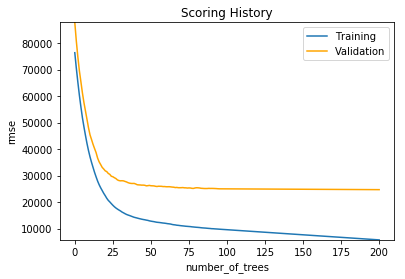

In [193]:
best_model.plot()

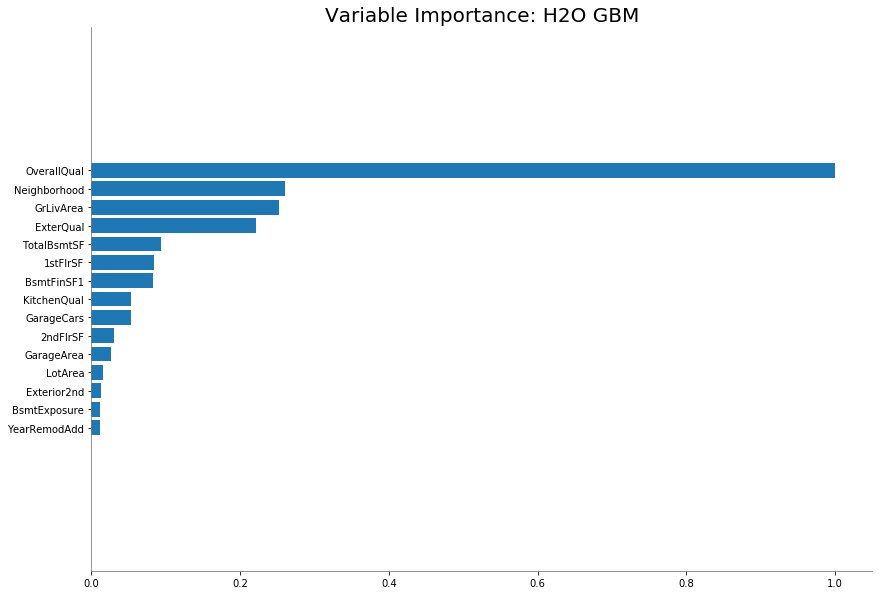

In [194]:
best_model.varimp_plot(15)

In [195]:
h2o.cluster().shutdown()

H2O session _sid_b9ed closed.


### Tree

In [34]:
from sklearn.tree import DecisionTreeRegressor

In [36]:
X_train = pd.get_dummies(X_train, drop_first=True) 
X_test = pd.get_dummies(X_test, drop_first=True) 

In [37]:
tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [38]:
from sklearn import tree
import pydotplus

In [39]:
tree.export_graphviz(tree_model, out_file="tree.dot")

In [44]:
tree_model.score(X_train, y_train)

1.0

In [45]:
tree_model.score(X_test, y_test)

ValueError: Number of features of the model must match the input. Model n_features is 251 and input n_features is 221 